In [218]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

In [219]:
!pip install keras-tuner

In [220]:
ticker_symbol = '^NSEI'
start_date = '2010-01-01'
end_date = '2021-12-01'
stock_data = yf.download(ticker_symbol, start = start_date, end = end_date)

df = pd.DataFrame(stock_data)

[*********************100%%**********************]  1 of 1 completed


In [221]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-24,17550.050781,17600.599609,17354.000000,17415.050781,17415.050781,298100
2021-11-25,17417.300781,17564.349609,17351.699219,17536.250000,17536.250000,255900
2021-11-26,17338.750000,17355.400391,16985.699219,17026.449219,17026.449219,356300
2021-11-29,17055.800781,17160.699219,16782.400391,17053.949219,17053.949219,348900
2021-11-30,17051.150391,17324.650391,16931.400391,16983.199219,16983.199219,498000


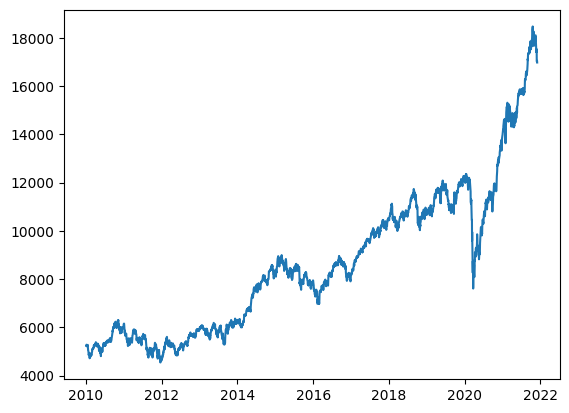

In [222]:
plt.plot(df['Adj Close'], label = 'Adj Close')

In [223]:
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

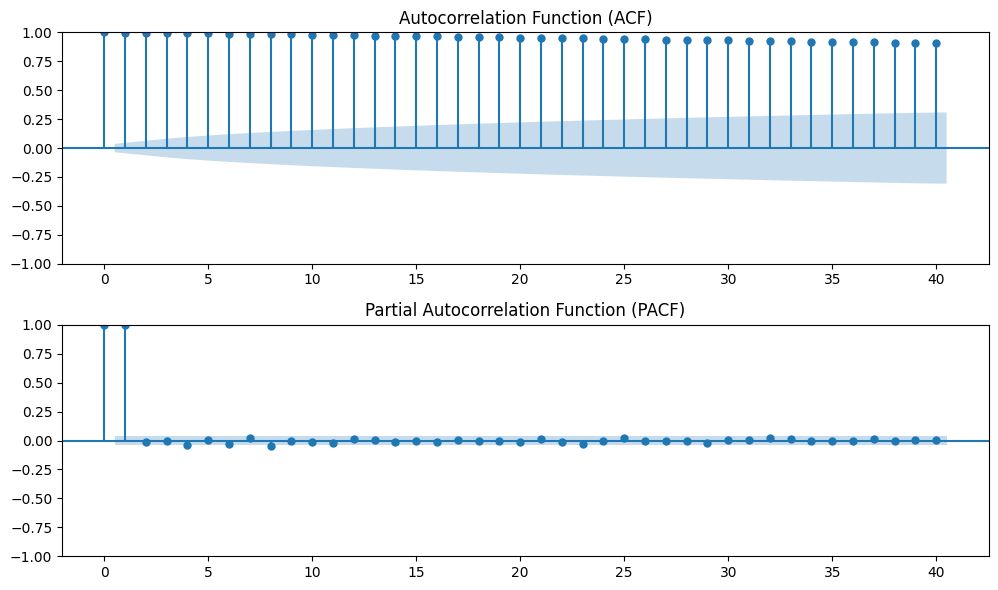

In [224]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(df['Adj Close'], lags=40, ax=ax1)
plot_pacf(df['Adj Close'], lags=40, ax=ax2)

# Set plot titles and labels
ax1.set_title('Autocorrelation Function (ACF)')
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

### Preparing the data for Autoencoder model


In [225]:
train = df[:int(0.7*len(df))]
test = df[int(0.7*len(df)):]

In [226]:
trainX, trainY = to_sequences(train[['Adj Close']], train['Adj Close'], seq_size = 2)

In [227]:
trainX.shape

(2040, 2, 1)

In [228]:
testX, testY = to_sequences(test[['Adj Close']], test['Adj Close'], seq_size = 2)

### STL decomposition

In [229]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [230]:
df.reset_index(inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'].dtype)
df.set_index('Date', inplace = True)

datetime64[ns]


In [231]:
df_close = df['Adj Close']

In [232]:
result = seasonal_decompose(df_close, model='additive', period=252)

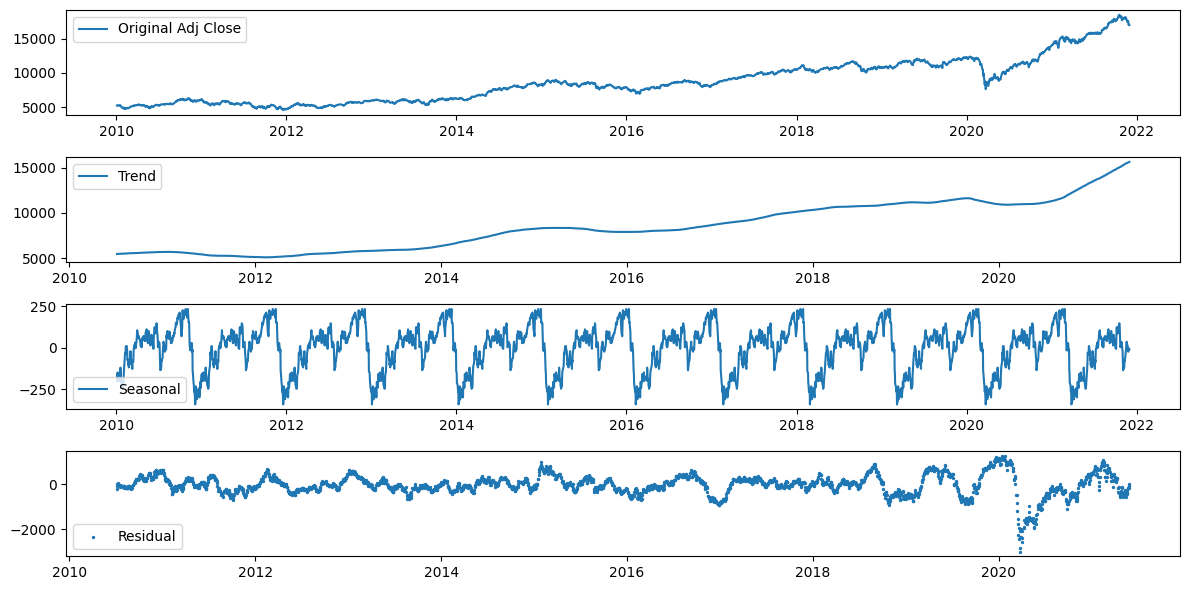

In [233]:
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(df['Adj Close'], label='Original Adj Close')
plt.legend()
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()
plt.subplot(414)
plt.scatter(df.index ,result.resid, label='Residual', s=2)
plt.legend()
plt.tight_layout()
plt.show()

In [234]:
df['residual'] = result.resid

In [235]:
df.isna().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
residual     252
dtype: int64

In [236]:
df.dropna(inplace = True)

In [237]:
result.resid.dropna(inplace = True)

In [238]:
result.resid.describe()

count    2666.000000
mean      -12.162327
std       457.968406
min     -3004.378112
25%      -229.058601
50%        -8.378164
75%       236.953485
max      1269.436585
Name: resid, dtype: float64

In [239]:
lower_band = result.resid.mean()-3*result.resid.std()
upper_band = result.resid.mean()+3*result.resid.std()

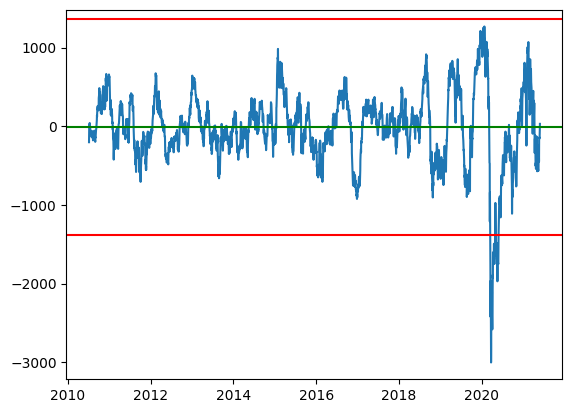

In [240]:
plt.plot(result.resid, label='Residual')
plt.axhline(y = lower_band, color = 'r', linestyle = '-')
plt.axhline(y = upper_band, color = 'r', linestyle = '-')
plt.axhline(y = result.resid.mean(), color = 'g', linestyle = '-')

In [241]:
df['anomaly'] = 0
for i in range(len(df)):
  if df['residual'].iloc[i] > upper_band or df['residual'].iloc[i] < lower_band:
    df['anomaly'].iloc[i] = 1

<ipython-input-241-40e46d4df8a0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'].iloc[i] = 1


In [242]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,residual,anomaly
Date,,,,,,,,
2010-07-07,5293.100098,5296.750000,5233.450195,5241.100098,5241.100098,0,-202.528603,0
2010-07-08,5242.000000,5320.500000,5242.000000,5296.850098,5296.850098,0,-92.474110,0
2010-07-09,5297.200195,5359.049805,5297.200195,5352.450195,5352.450195,0,14.270577,0
2010-07-12,5352.250000,5402.700195,5351.600098,5383.000000,5383.000000,0,37.497210,0
2010-07-13,5370.200195,5406.200195,5357.850098,5400.649902,5400.649902,0,41.833231,0


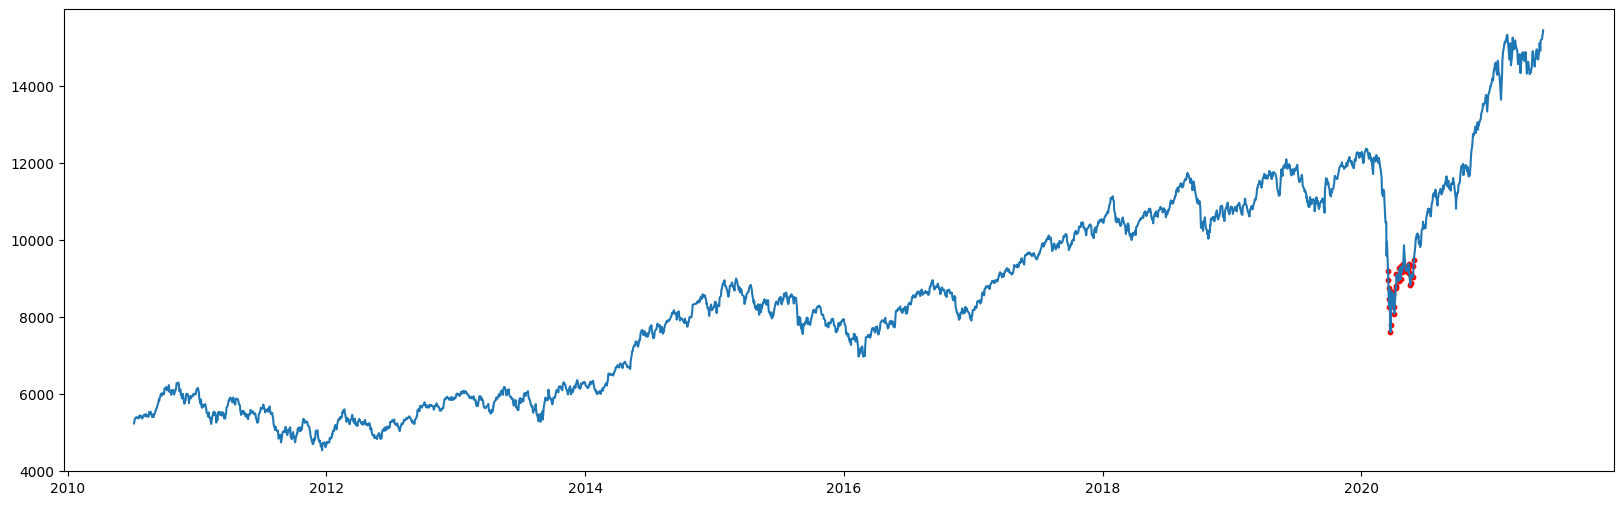

In [243]:
plt.figure(figsize=(20, 6))
df_filter = df[df['anomaly'] == 1]

plt.plot(df['Adj Close'])
plt.scatter(df_filter.index, df_filter['Adj Close'], c='red', s= 10)

### Isolation Forest for Anomaly Detection



In [244]:
close_values = df['Adj Close']
close_values.head()

Date
2010-07-07    5241.100098
2010-07-08    5296.850098
2010-07-09    5352.450195
2010-07-12    5383.000000
2010-07-13    5400.649902
Name: Adj Close, dtype: float64

In [245]:
# Scaling the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
close_values = np.array(close_values).reshape(-1, 1)
close_values = pd.DataFrame(scaler.fit_transform(close_values), index = df.index)

In [246]:
from sklearn.ensemble import IsolationForest
outlier_fraction = 0.03                                               # based on previous evaluation using seasonal decomposition
model = IsolationForest(contamination= outlier_fraction)
model.fit(close_values)

IsolationForest(contamination=0.03)

In [247]:
close_values['anomaly'] = model.predict(close_values)

In [248]:
close_values.columns = ['adj close', 'anomaly']

In [249]:
close = np.array(close_values['adj close']).reshape(-1, 1)
close = scaler.inverse_transform(close)

In [250]:
close_values['adj close'] = close

In [251]:
close_values.head()

,adj close,anomaly
Date,,
2010-07-07,5241.100098,1
2010-07-08,5296.850098,1
2010-07-09,5352.450195,1
2010-07-12,5383.000000,1
2010-07-13,5400.649902,1


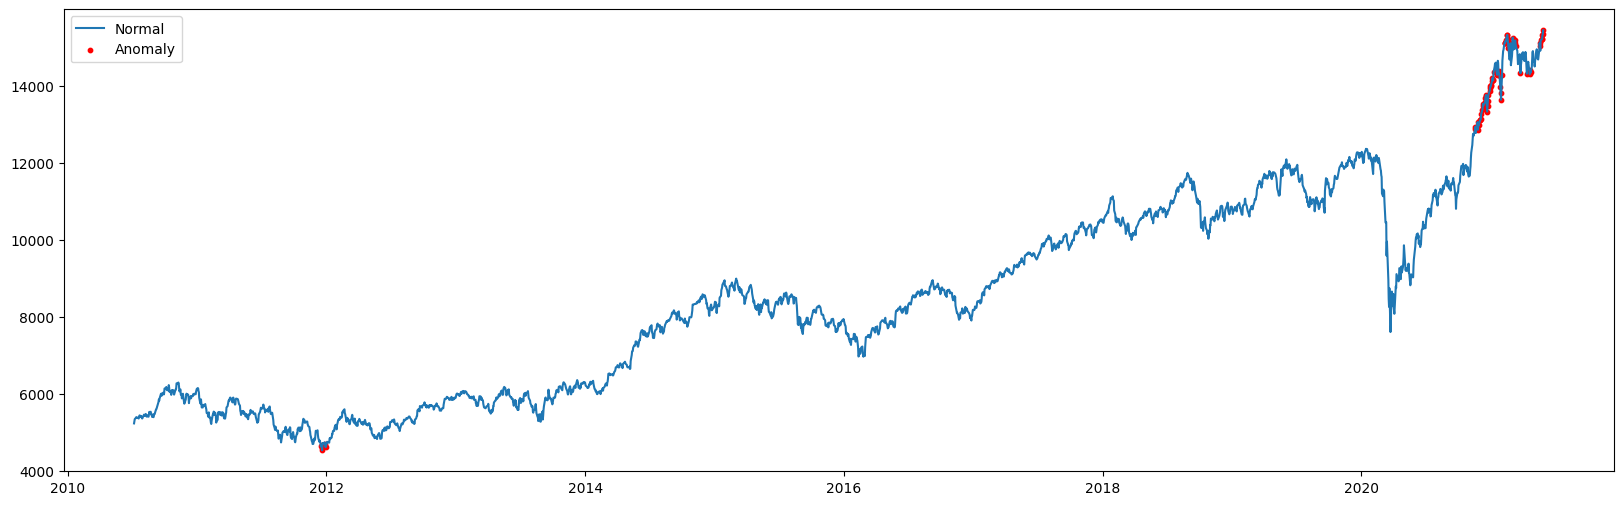

In [252]:
fig, ax = plt.subplots(figsize = (20, 6))
a = close_values.loc[close_values['anomaly'] == -1, ['adj close']]
ax.plot(close_values.index, close_values['adj close'],label = 'Normal')
ax.scatter(a.index, a['adj close'], color = 'red', label = 'Anomaly', s=10)
plt.legend()

### LSTM Autoencoders for Anomaly detection

In [253]:
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

In [254]:
trainY.shape

(2040,)

In [312]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=16), input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)))

    model.add(RepeatVector(trainX.shape[1]))

    model.add(LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=16), return_sequences=True))
    #model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.01)))
    model.add(TimeDistributed(Dense(trainX.shape[2])))

    model.compile(optimizer='adam', loss='mae')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of different hyperparameter combinations to try
    directory='my_dir',  # Directory where the search results are stored
    project_name='my_project'  # Name for the search project
)



# Perform the hyperparameter search
tuner.search(trainX, trainY, epochs=50, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = build_model(best_hps)

Reloading Tuner from my_dir/my_project/tuner0.json


Epoch 1/50
115/115 [==============================] - 3s 26ms/step - loss: 4149.9712 - val_loss: 7695.0464
Epoch 2/50
115/115 [==============================] - 3s 22ms/step - loss: 4122.7964 - val_loss: 7669.7012
Epoch 3/50
115/115 [==============================] - 3s 23ms/step - loss: 4098.4282 - val_loss: 7644.3633
Epoch 4/50
115/115 [==============================] - 3s 23ms/step - loss: 4072.4443 - val_loss: 7619.0127
Epoch 5/50
115/115 [==============================] - 4s 33ms/step - loss: 4049.0032 - val_loss: 7593.6680
Epoch 6/50
115/115 [==============================] - 3s 23ms/step - loss: 4023.9795 - val_loss: 7568.3140
Epoch 7/50
115/115 [==============================] - 3s 22ms/step - loss: 3996.1453 - val_loss: 7542.9370
Epoch 8/50
115/115 [==============================] - 3s 22ms/step - loss: 3970.1973 - val_loss: 7517.5537
Epoch 9/50
115/115 [==============================] - 3s 26ms/step - loss: 3945.8792 - val_loss: 7492.1680
Epoch 10/50
115/115 [================

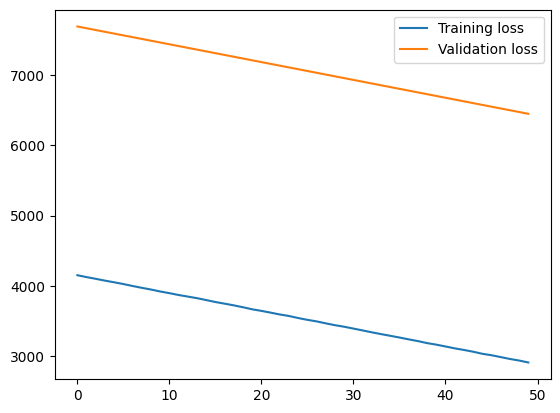

In [323]:
history = best_model.fit(trainX, trainY, epochs=50, batch_size=16, verbose=1, validation_split = 0.1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()



In [324]:
best_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 256)               264192    
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 repeat_vector_18 (RepeatVe  (None, 2, 256)            0         
 ctor)                                                           
                                                                 
 lstm_43 (LSTM)              (None, 2, 256)            525312    
                                                                 
 dropout_37 (Dropout)        (None, 2, 256)            0         
                                                                 
 time_distributed_18 (TimeD  (None, 2, 1)              257       
 istributed)                                         

In [325]:
trainPredict = best_model.predict(trainX)
trainPredict.shape


64/64 [==============================] - 1s 8ms/step


(2040, 2, 1)

(array([ 13.,  63.,  68., 101., 167., 129., 106., 102., 129., 105.,  41.,
         10.,  10.,  20.,   5.,  12.,  17.,  30.,  52.,  67.,  82.,  73.,
         80.,  84.,  87.,  71.,  32.,  15.,  15.,  17.,  22.,  18.,  34.,
         27.,  36.,  42.,  33.,  14.,   4.,   7.]),
 array([ 748.98852539,  912.02290649, 1075.0572876 , 1238.0916687 ,
        1401.1260498 , 1564.16043091, 1727.19481201, 1890.22919312,
        2053.26357422, 2216.29795532, 2379.33233643, 2542.36671753,
        2705.40109863, 2868.43547974, 3031.46986084, 3194.50424194,
        3357.53862305, 3520.57300415, 3683.60738525, 3846.64176636,
        4009.67614746, 4172.71052856, 4335.74490967, 4498.77929077,
        4661.81367187, 4824.84805298, 4987.88243408, 5150.91681519,
        5313.95119629, 5476.98557739, 5640.0199585 , 5803.0543396 ,
        5966.0887207 , 6129.12310181, 6292.15748291, 6455.19186401,
        6618.22624512, 6781.26062622, 6944.29500732, 7107.32938843,
        7270.36376953]),
 <BarContainer object

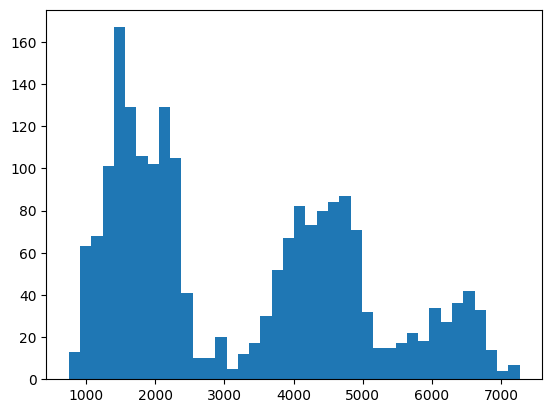

In [326]:
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=40)

In [327]:
max_trainMAE = 9000

28/28 [==============================] - 0s 8ms/step


(array([  1.,   3.,   7.,   3.,   7.,  21.,   6.,   3.,  14.,  24.,  41.,
        109.,  74.,  84.,  84.,  75.,  52.,   7.,   5.,   9.,   4.,   9.,
          6.,   9.,  13.,  25.,  27.,  21.,   6.,  25.,  21.,   6.,   6.,
          6.,   3.,   9.,  12.,  16.,  14.,   7.]),
 array([ 3875.98828125,  4144.54454346,  4413.10080566,  4681.65706787,
         4950.21333008,  5218.76959229,  5487.32585449,  5755.8821167 ,
         6024.43837891,  6292.99464111,  6561.55090332,  6830.10716553,
         7098.66342773,  7367.21968994,  7635.77595215,  7904.33221436,
         8172.88847656,  8441.44473877,  8710.00100098,  8978.55726318,
         9247.11352539,  9515.6697876 ,  9784.2260498 , 10052.78231201,
        10321.33857422, 10589.89483643, 10858.45109863, 11127.00736084,
        11395.56362305, 11664.11988525, 11932.67614746, 12201.23240967,
        12469.78867187, 12738.34493408, 13006.90119629, 13275.4574585 ,
        13544.0137207 , 13812.56998291, 14081.12624512, 14349.68250732,
      

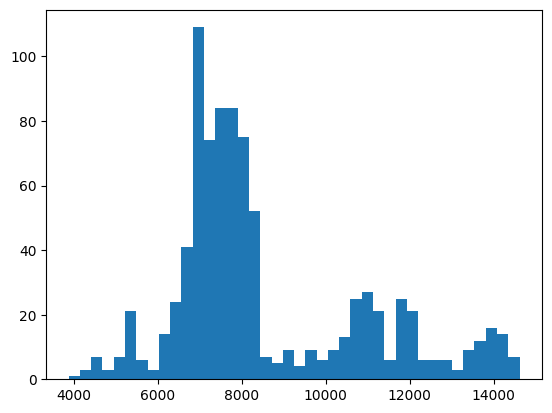

In [328]:
testPredict = best_model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=40)

In [329]:
anomaly_df = pd.DataFrame(test[2:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = (anomaly_df['testMAE'] > anomaly_df['max_trainMAE']).astype(int)
anomaly_df['Adj Close'] = test[2:]['Adj Close']

In [330]:
#anomaly_df.reset_index(inplace = True)
anomaly_df.head()

,Open,High,Low,Close,Adj Close,Volume,testMAE,max_trainMAE,anomaly
Date,,,,,,,,,
2018-05-11,10741.950195,10812.049805,10724.450195,10806.500000,10806.500000,203100,6899.463379,9000,0
2018-05-14,10815.150391,10834.849609,10774.750000,10806.599609,10806.599609,171400,6931.863281,9000,0
2018-05-15,10812.599609,10929.200195,10781.400391,10801.849609,10801.849609,254300,6976.888184,9000,0
2018-05-16,10751.950195,10790.450195,10699.700195,10741.099609,10741.099609,231100,6974.562988,9000,0
2018-05-17,10775.599609,10777.250000,10664.500000,10682.700195,10682.700195,214100,6941.812988,9000,0


In [331]:
anomaly_df['anomaly'].unique()

array([0, 1])

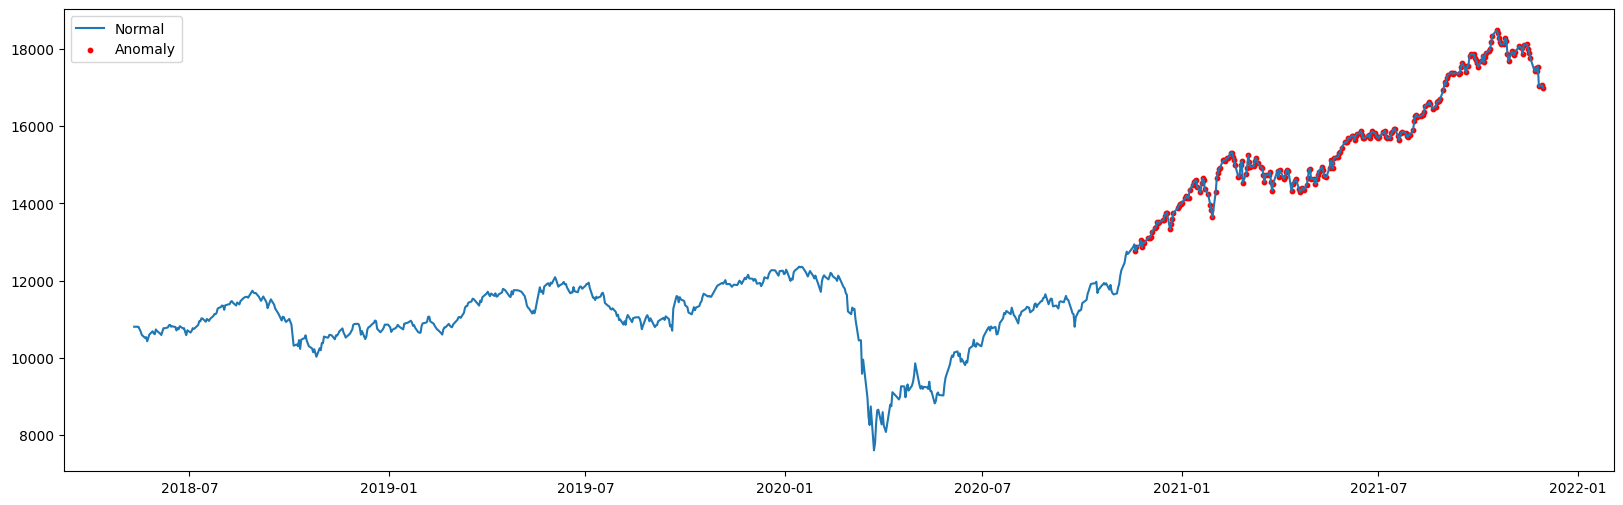

In [332]:
#sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
#sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
#sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(np.array(anomaly_df['Close']).reshape(-1, 1)))
#sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(np.array(anomalies['Close']).reshape(-1, 1)), color='r')

fig, ax = plt.subplots(figsize = (20, 6))
a = anomaly_df.loc[anomaly_df['anomaly'] == 1, ['Adj Close']]
ax.plot(anomaly_df.index, anomaly_df['Adj Close'],label = 'Normal')
ax.scatter(a.index, a['Adj Close'], color = 'red', label = 'Anomaly', s=10)
plt.legend()